### LSTM Time Series Forecasting Model for Stock Market Prediction

##### Step 1 ...  Loading Required Packages

In [11]:
import math                                                         # Mathematical functions 
import numpy as np                                                  # Fundamental package for scientific computing with Python
import pandas as pd                                                 # Panadas functions for analysing and manipulating data
import seaborn as sns                                               # Visualization
import matplotlib.dates as mdates                                   # Formatting dates
import matplotlib.pyplot as plt                                     # Visualization
import matplotlib.dates as mdates                                   # Formatting dates
import tensorflow as tf                                             # Import tensorflow
from datetime import date, timedelta, datetime                      # Date Functions
from pandas.plotting import register_matplotlib_converters          # This function adds plotting functions for calender dates
from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from tensorflow.keras import Sequential                             # Deep learning library, used for neural networks
from tensorflow.keras.callbacks import EarlyStopping                # EarlyStopping during model training
from tensorflow.keras.layers import LSTM, Dense, Dropout            # Deep learning classes for recurrent and regular densely-connected layers
from tensorflow.keras.callbacks import EarlyStopping                # EarlyStopping during model training
from sklearn.preprocessing import RobustScaler, MinMaxScaler        # To normalize the price data 

import warnings
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')

# check the tensorflow version and the number of available GPUs
print('Tensorflow Version: ' + tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

# Loading and preprocessing the data
if __name__ == '__main__':
    stock_symbol = 'HINDUNILVR.NS'
    stock_name = 'Hindustan Unilever (INR)'
    start_date, end_date = '2018-04-01', '2023-08-01'
    sequence_length = 50
    FEATURES = ['Close', 'WMA', 'DEMA', 'ZLEMA', 'DayRange', 'RevenuePerShare', 'EPS']

Tensorflow Version: 2.10.0
Num GPUs: 0


##### Step 2 ... Exploring the Data

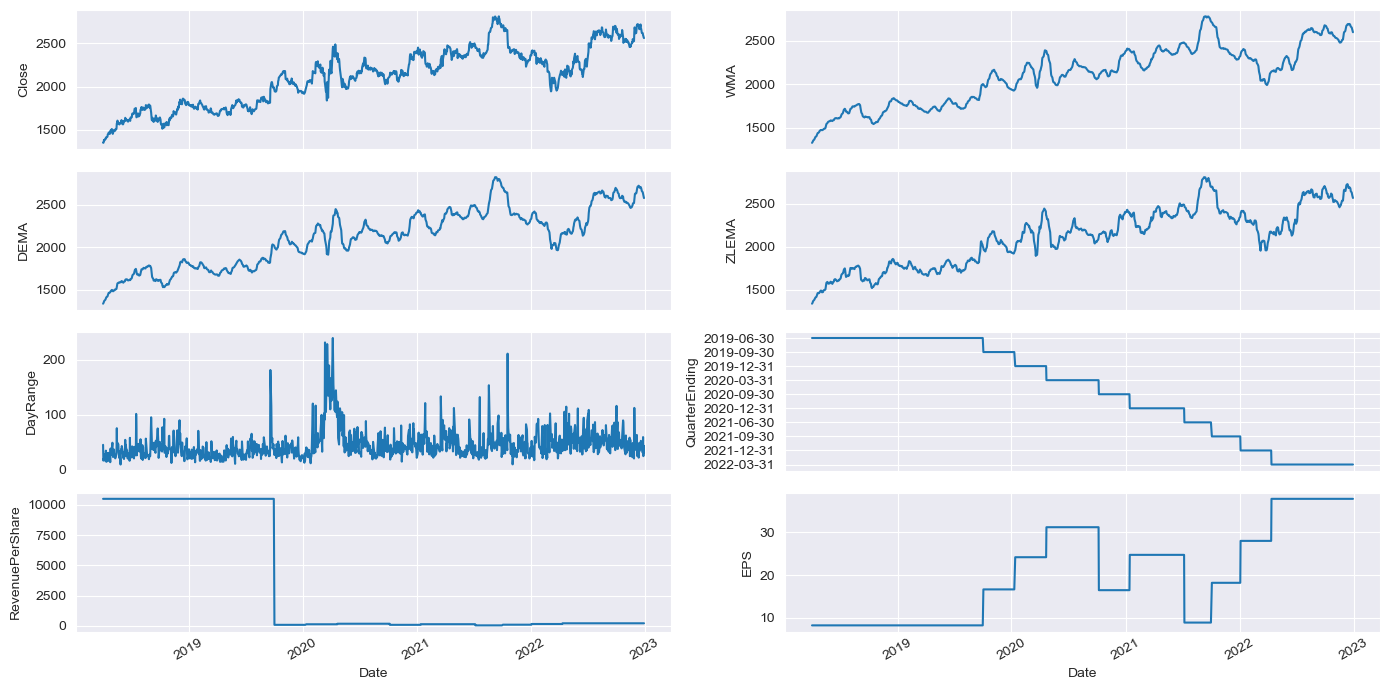

In [13]:
def load_and_preprocess_data(stock_symbol, start_date, end_date):
    fundamental_df = pd.read_csv(f'{stock_symbol}_Fundamental_data.csv', parse_dates=True, index_col=0)
    technical_df = pd.read_csv(f'{stock_symbol}_technical_data.csv', parse_dates=True, index_col=0)
    technical_df = technical_df[['Close', 'High', 'Low', 'WMA', 'DEMA', 'ZLEMA']]
    technical_df['DayRange'] = technical_df['High'] - technical_df['Low']
    technical_df.drop(['High', 'Low'], axis=1, inplace=True)
    technical_df.dropna(inplace=True)
    df = technical_df.merge(fundamental_df, how='left', left_index=True, right_index=True)
    df.fillna(method='ffill', inplace=True)  # forward fill the fundamental data
    df.fillna(method='bfill', inplace=True)  # backward fill if there are any NaNs left
    return df[start_date:end_date]

def plot_features(df_plot):
    ncols = 2
    nrows = int(round(df_plot.shape[1] / ncols, 0))
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
    for i, ax in enumerate(fig.axes):
        sns.lineplot(data=df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    fig.tight_layout()
    plt.show()

if __name__ == '__main__':
    df = load_and_preprocess_data(stock_symbol, start_date, end_date)
    df_plot = df.copy()
    df.drop(['QuarterEnding'], axis=1, inplace=True)

    plot_features(df_plot)

##### Step 3 ... Feature Selection

In [3]:
def data_scaling(df, FEATURES):
    feature_data = df[FEATURES].drop(columns=['Close'])
    target_data = df['Close'].values.reshape(-1, 1)
    feature_scaler, target_scaler = MinMaxScaler(), MinMaxScaler()
    scaled_features = feature_scaler.fit_transform(feature_data)
    scaled_target = target_scaler.fit_transform(target_data)
    return np.concatenate([scaled_target, scaled_features], axis=1), feature_scaler, target_scaler

print('FEATURE LIST')
print([f for f in FEATURES])

FEATURE LIST
['Close', 'WMA', 'DEMA', 'ZLEMA', 'DayRange', 'RevenuePerShare', 'EPS']


##### Step 4 ... Model Training

In [4]:
# The RNN needs data with the format of [samples, time steps, features]
# Create N samples, sequence_length time steps per sample, and features
def partition_dataset(sequence_length, data):
    x, y = [], []
    for i in range(sequence_length, len(data)):
        x.append(data[i-sequence_length:i])
        y.append(data[i, 0]) # Because now 'Close' is the first column
    return np.array(x), np.array(y)

# Configure the neural network model
# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
def build_lstm_model(input_shape):
    model = Sequential()
    n_neurons = input_shape[0] * input_shape[1]
    model.add(LSTM(n_neurons, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(n_neurons, return_sequences=False))
    model.add(Dense(5))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

if __name__ == '__main__':
    scaled_data, feature_scaler, target_scaler = data_scaling(df, FEATURES)
    train_data_len = math.ceil(len(scaled_data) * 0.8)
    train_data = scaled_data[:train_data_len]
    test_data = scaled_data[train_data_len - sequence_length:]

    # Generate training data and test data
    x_train, y_train = partition_dataset(sequence_length, train_data)
    x_test, y_test = partition_dataset(sequence_length, test_data)

    # Configure the neural network model
    model = build_lstm_model((x_train.shape[1], x_train.shape[2]))
    
    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
    history = model.fit(x_train, y_train, batch_size=16, epochs=50, validation_data=(x_test, y_test))

Epoch 1/50
56/56 [==============================] - 23s 251ms/step - loss: 0.0154 - val_loss: 0.0036
Epoch 2/50
56/56 [==============================] - 13s 231ms/step - loss: 0.0020 - val_loss: 0.0042
Epoch 3/50
56/56 [==============================] - 19s 344ms/step - loss: 0.0020 - val_loss: 0.0059
Epoch 4/50
56/56 [==============================] - 13s 235ms/step - loss: 0.0015 - val_loss: 0.0034
Epoch 5/50
56/56 [==============================] - 12s 212ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 6/50
56/56 [==============================] - 13s 238ms/step - loss: 0.0013 - val_loss: 0.0041
Epoch 7/50
56/56 [==============================] - 14s 254ms/step - loss: 0.0013 - val_loss: 0.0025
Epoch 8/50
56/56 [==============================] - 13s 222ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 9/50
56/56 [==============================] - 13s 236ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 10/50
56/56 [==============================] - 14s 244ms/step - loss: 0.0010 - val_lo

##### Step 5 ... Model Performance Evaluation

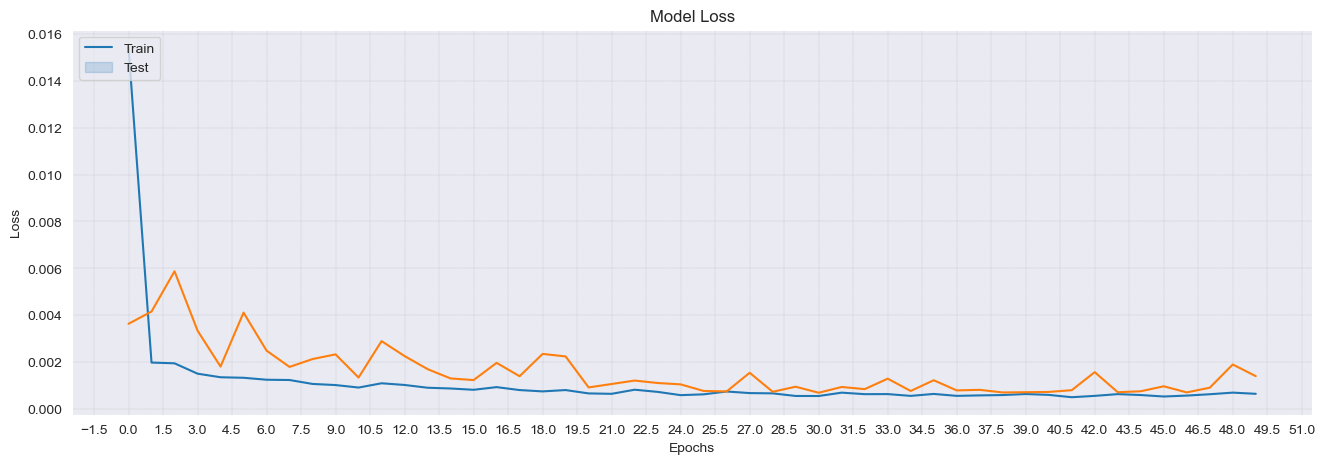

In [5]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"], label="Training Loss")
sns.lineplot(data=history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
ax.xaxis.set_major_locator(plt.MaxNLocator(sequence_length))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid(color="grey", linestyle="--", linewidth=0.25, alpha=0.5)
plt.show()

##### Step 6 ... Next Day's Price Prediction

1/1 [==============================] - 0s 69ms/step

The last actual close price is: 2561.05
The predicted next close price is: 2554.07



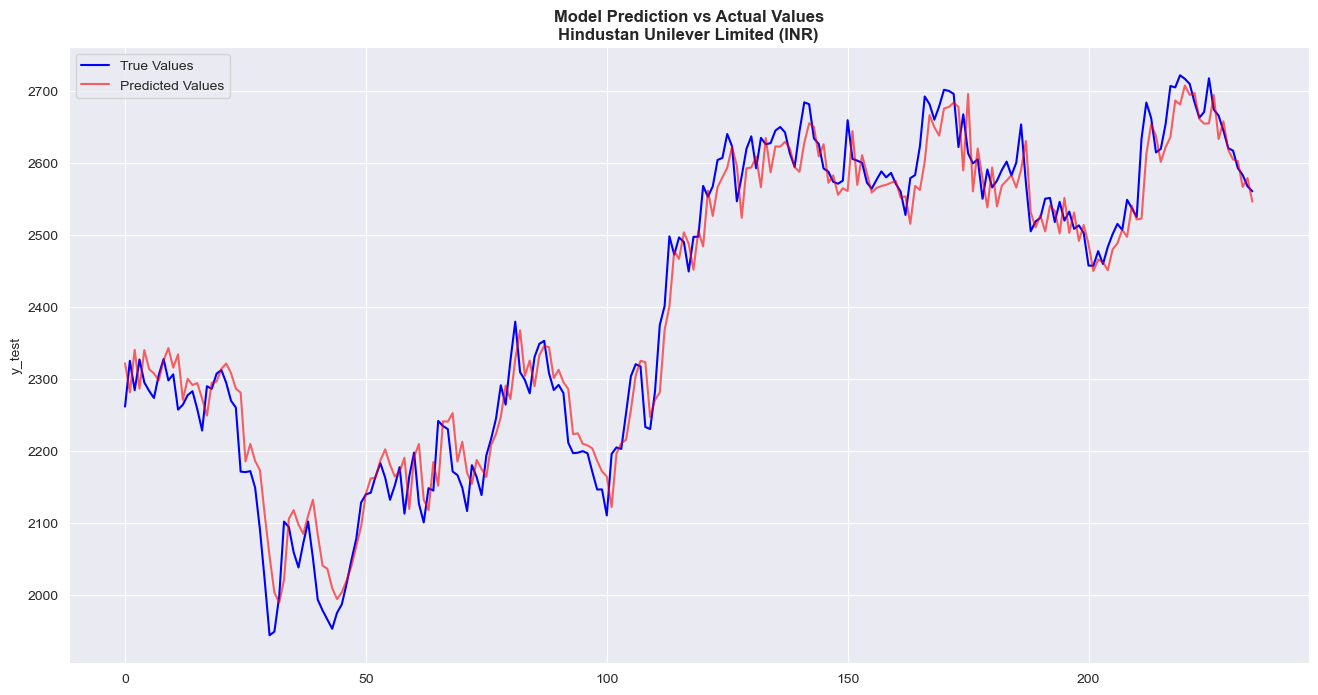

In [23]:
# === Plotting Predicted vs. Real Prices ===

y_pred_scaled = model.predict(x_test)
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = target_scaler.inverse_transform(y_test.reshape(-1, 1))

# === Rebalancing the Model Prediction ===

# Create a DataFrame to hold the real and predicted values
valid = pd.DataFrame(y_test_unscaled, columns=['y_test'])
valid['y_pred'] = y_pred
valid['residuals'] = valid['y_test'] - valid['y_pred']
mean_res = valid['residuals'].mean()
valid['y_pred'] = y_pred + mean_res
valid.drop('residuals', axis=1, inplace=True)

# === Predicting the Next Day Price ===

last_sequence = scaled_data[-sequence_length:]
next_day_prediction_scaled = model.predict(last_sequence[np.newaxis, :, :])
next_day_prediction = target_scaler.inverse_transform(next_day_prediction_scaled)[0][0] + mean_res

print(f'\nThe last actual close price is: {df["Close"].values[-1]:.2f}')
print(f'The predicted next close price is: {next_day_prediction:.2f}\n')

# Plot
plt.figure(figsize=(16, 8))
plt.title('Model Prediction vs Actual Values'+ '\n' + stock_name, fontsize=12, fontweight='bold')
sns.lineplot(data=valid['y_test'], label='True Values', color='blue')
sns.lineplot(data=valid['y_pred'], label='Predicted Values', color='red', alpha=0.6)
plt.legend()
plt.show()

##### Step 7 ... Statstics Evaluation

MAE: 45.46

RMSE: 54.99

Mean Residual: -0.00

Standard Deviation of Residuals: 41.09

Mean Absolute Percentage Error (MAPE): 1.37%



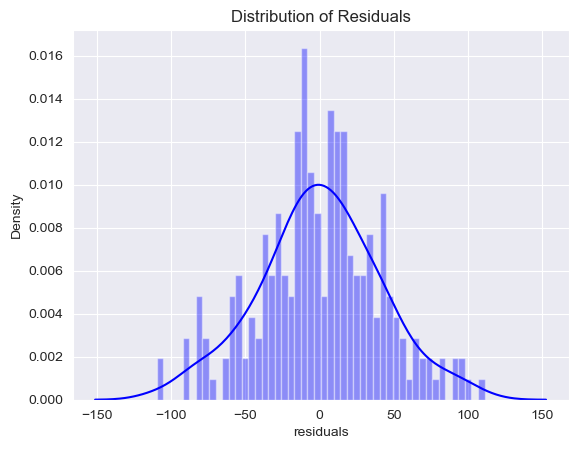

In [7]:
# === Additional Statistics for Analysis ===

valid['residuals'] = valid['y_test'] - valid['y_pred']
mean_residual = valid['residuals'].mean()
std_residual = valid['residuals'].std()

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'MAE: {np.round(MAE, 2)}\n')

# Root Mean Squared Error (RMSE)
RMSE = mean_squared_error(y_test_unscaled, y_pred, squared=False)
print(f'RMSE: {RMSE:.2f}\n')

# Mean Absolute Percentage Error (MAPE)
valid['APE'] = 100 * (valid['residuals'].abs() / valid['y_test'])
MAPE = valid['APE'].mean()

print(f'Mean Residual: {mean_residual:.2f}\n')
print(f'Standard Deviation of Residuals: {std_residual:.2f}\n')
print(f'Mean Absolute Percentage Error (MAPE): {MAPE:.2f}%\n')

# Distribution plot of residuals
sns.distplot(valid['residuals'], bins=50, color='blue').set_title("Distribution of Residuals")
plt.show()

-----